In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer, KNNImputer
import umap
import scipy.cluster.hierarchy as sch
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Part 1: Data Preparation and Exploration

=== PART 1: Data Preparation and Exploration ===
Dataset Shape: (891, 15)

Missing Values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          

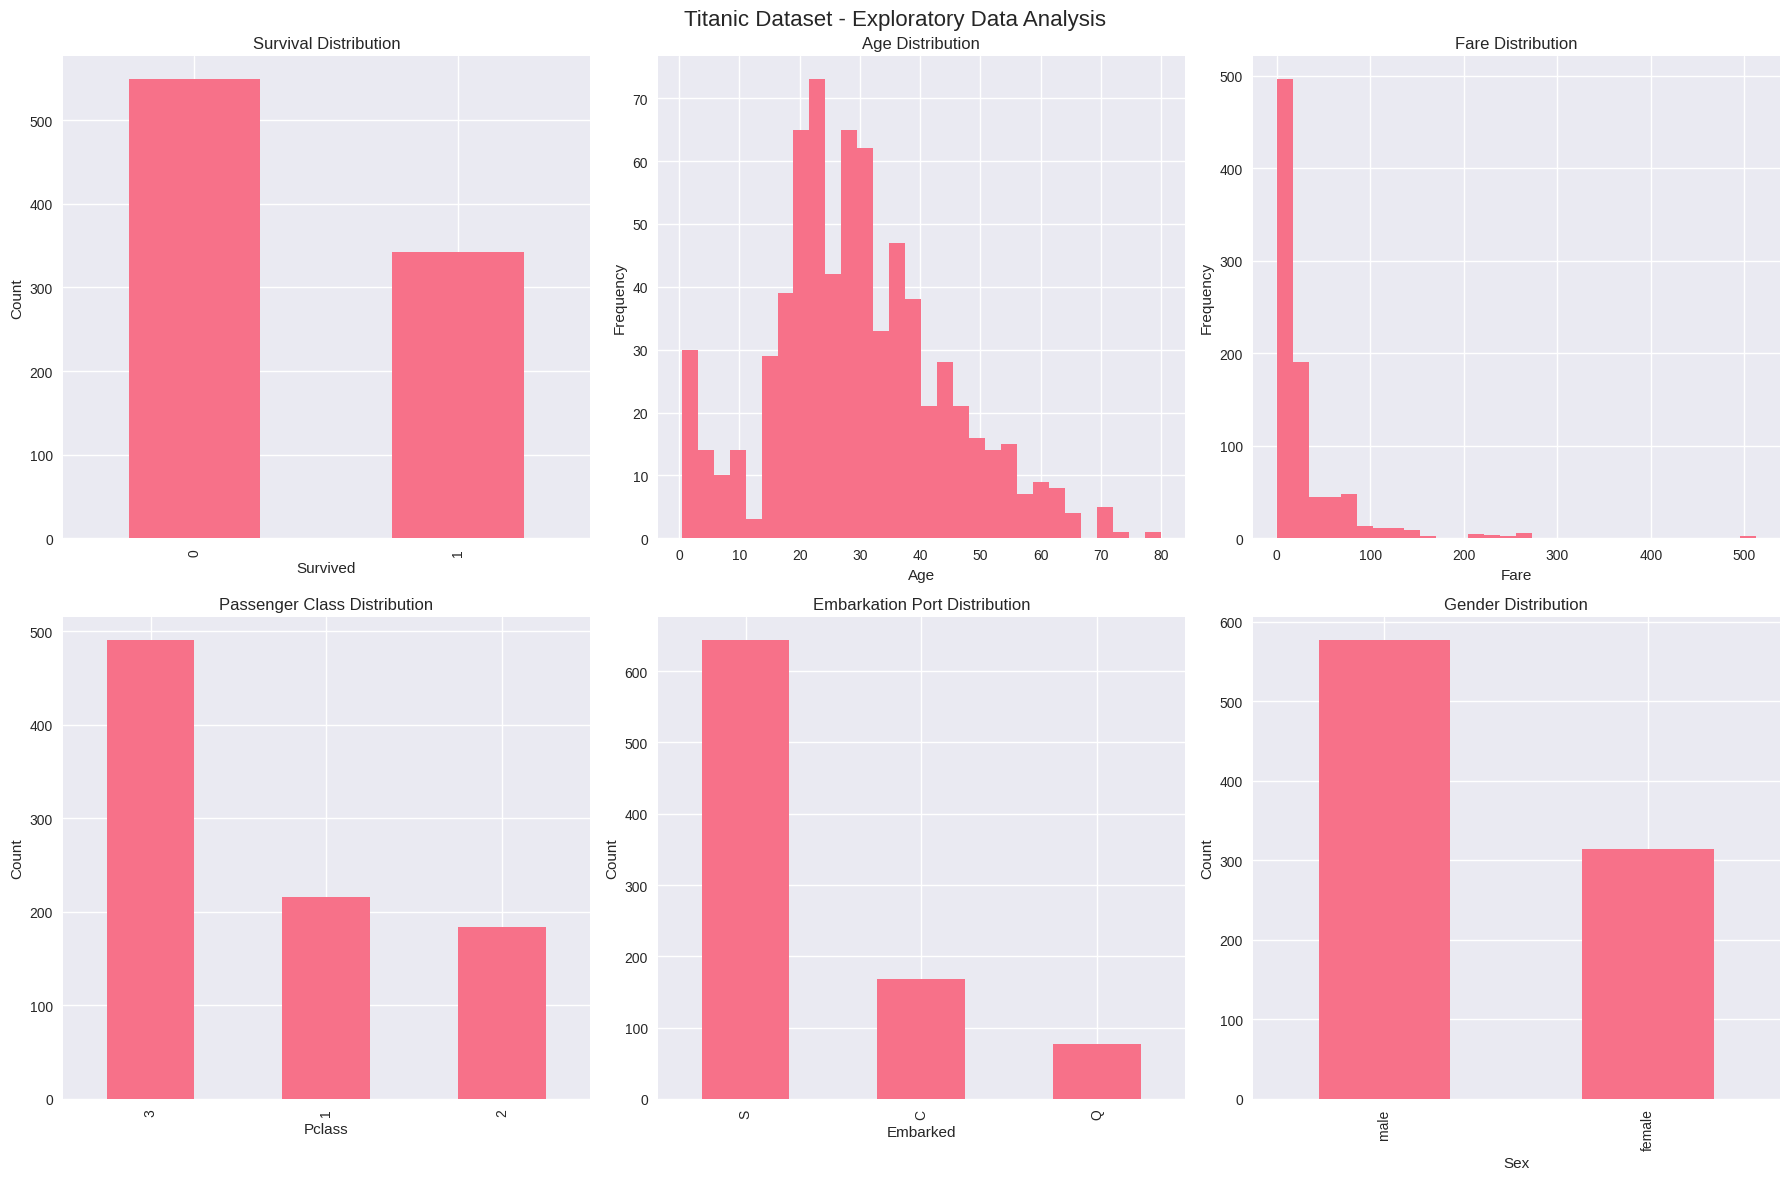

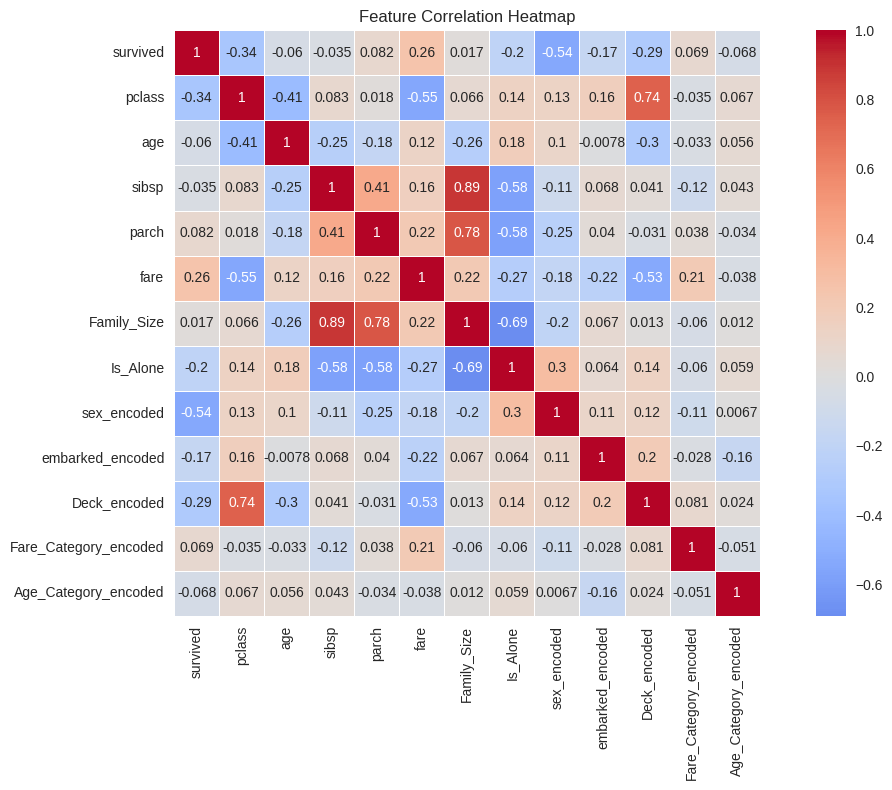

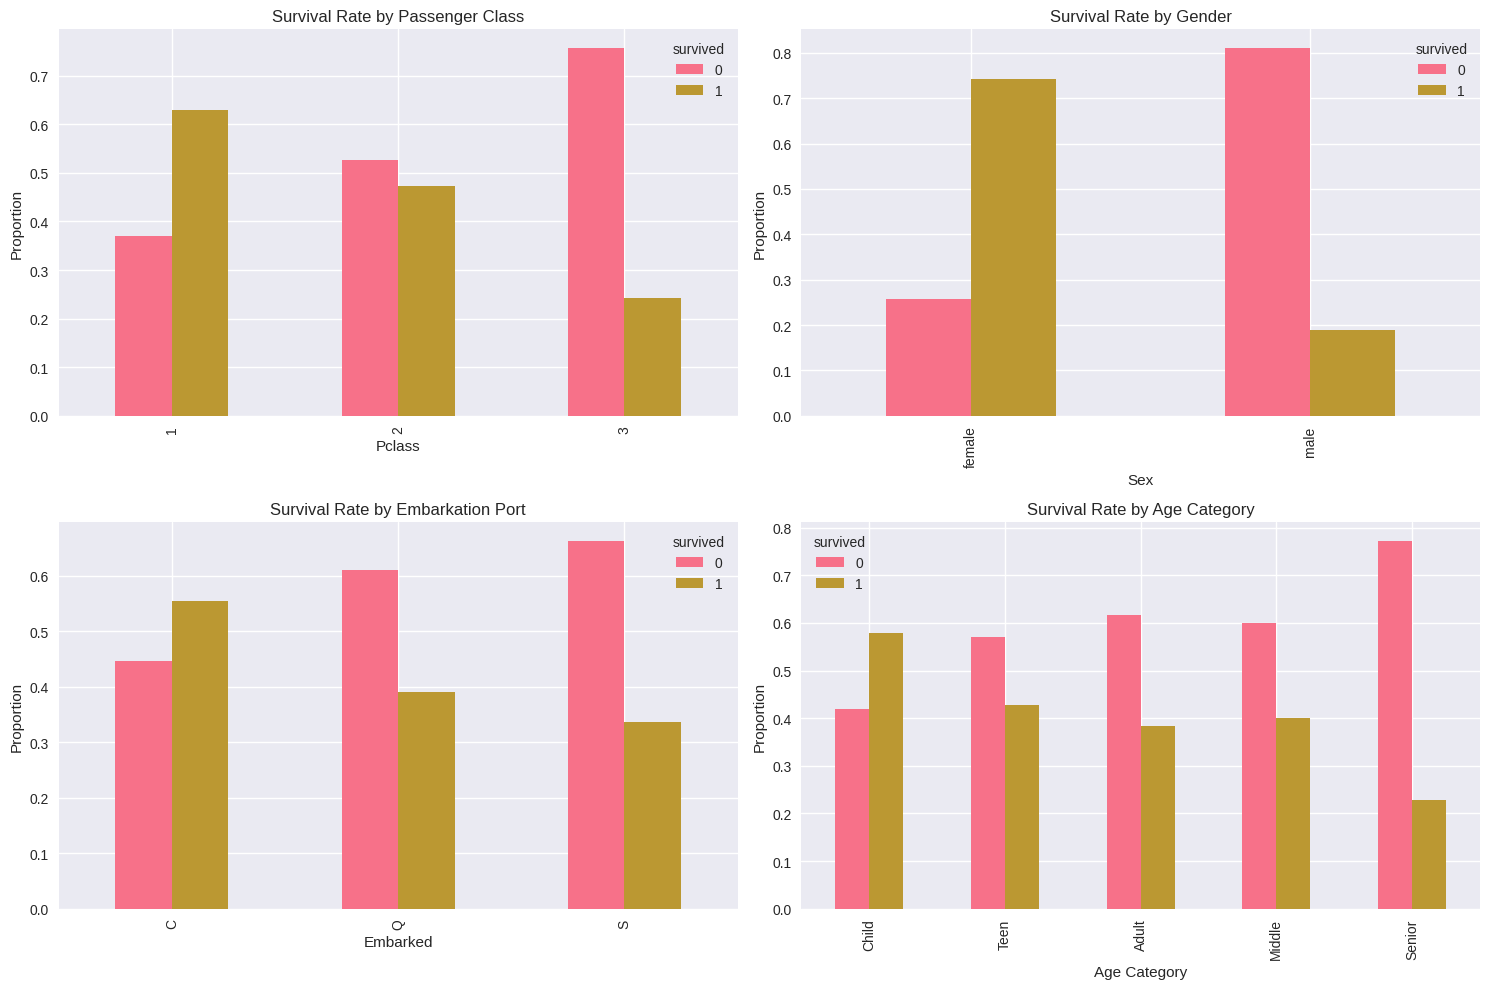

In [2]:
def preprocess_data(df):
    """
    Preprocess the Titanic dataset for clustering analysis
    """
    data = df.copy()

    # Feature Engineering
    data['Family_Size'] = data['sibsp'] + data['parch'] + 1
    data['Is_Alone'] = (data['Family_Size'] == 1).astype(int)

    # data['Title'] = data['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don',
    #                                        'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # data['Title'] = data['Title'].replace('Mlle', 'Miss')
    # data['Title'] = data['Title'].replace('Ms', 'Miss')
    # data['Title'] = data['Title'].replace('Mme', 'Mrs')

    # Fare categories
    data['Fare_Category'] = pd.cut(data['fare'],
                                  bins=[-1, 10, 30, 100, 600],
                                  labels=['Low', 'Medium', 'High', 'Very High'])

    # Age categories
    data['Age_Category'] = pd.cut(data['age'],
                                 bins=[0, 12, 18, 35, 60, 100],
                                 labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])


    data['Deck'] = data['deck'].str[0]
    data['Has_Cabin'] = data['cabin'].notna().astype(int)


    # Age - median based on Pclass and Sex
    data['age'] = data.groupby(['pclass', 'sex'])['age'].transform(
        lambda x: x.fillna(x.median()))


    data['age'].fillna(data['age'].median(), inplace=True)

    # Embarked - mode
    data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)

    # Fare - median based on Pclass
    data['fare'] = data.groupby('pclass')['fare'].transform(
        lambda x: x.fillna(x.median()))


    data['Deck'].fillna('Unknown', inplace=True)

    # features for clustering
    clustering_features = [
        'pclass', 'age', 'sibsp', 'parch', 'fare', 'Family_Size',
        'Is_Alone', 'Has_Cabin'
    ]


    X = data[clustering_features].copy()


    categorical_features = ['sex', 'embarked', 'Deck', 'Fare_Category', 'Age_Category']
    label_encoders = {}

    for feature in categorical_features:
        le = LabelEncoder()
        data[f'{feature}_encoded'] = le.fit_transform(data[feature].astype(str))
        label_encoders[feature] = le


    X_encoded = X.copy()
    for feature in ['sex', 'embarked']:
        X_encoded[f'{feature}_encoded'] = data[f'{feature}_encoded']


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_encoded_scaled = scaler.fit_transform(X_encoded)

    return {
        'data': data,
        'X': X,
        'X_scaled': X_scaled,
        'X_encoded': X_encoded,
        'X_encoded_scaled': X_encoded_scaled,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'clustering_features': clustering_features
    }

# data and processing
def load_and_explore_data():
    """Load Titanic dataset and perform initial exploration"""
    try:

        df = sns.load_dataset('titanic')
    except:

        import io
        import requests
        url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
        df = pd.read_csv(url)

    print("Dataset Shape:", df.shape)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDataset Info:")
    print(df.info())

    return df

# exploratory data analysis
def exploratory_data_analysis(df, preprocessed_data):
    """Comprehensive EDA for Titanic dataset"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16)

    # Survival distribution
    df['survived'].value_counts().plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Survival Distribution')
    axes[0,0].set_xlabel('Survived')
    axes[0,0].set_ylabel('Count')

    # Age distribution
    df['age'].hist(bins=30, ax=axes[0,1])
    axes[0,1].set_title('Age Distribution')
    axes[0,1].set_xlabel('Age')
    axes[0,1].set_ylabel('Frequency')

    # Fare distribution
    df['fare'].hist(bins=30, ax=axes[0,2])
    axes[0,2].set_title('Fare Distribution')
    axes[0,2].set_xlabel('Fare')
    axes[0,2].set_ylabel('Frequency')

    # Pclass distribution
    df['pclass'].value_counts().plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Passenger Class Distribution')
    axes[1,0].set_xlabel('Pclass')
    axes[1,0].set_ylabel('Count')

    # Embarked distribution
    df['embarked'].value_counts().plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Embarkation Port Distribution')
    axes[1,1].set_xlabel('Embarked')
    axes[1,1].set_ylabel('Count')

    # Sex distribution
    df['sex'].value_counts().plot(kind='bar', ax=axes[1,2])
    axes[1,2].set_title('Gender Distribution')
    axes[1,2].set_xlabel('Sex')
    axes[1,2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    numeric_df = preprocessed_data['data'].select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Survival analysis by key features
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Survival by Pclass
    pd.crosstab(df['pclass'], df['survived'], normalize='index').plot(
        kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Survival Rate by Passenger Class')
    axes[0,0].set_xlabel('Pclass')
    axes[0,0].set_ylabel('Proportion')

    # Survival by Sex
    pd.crosstab(df['sex'], df['survived'], normalize='index').plot(
        kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Survival Rate by Gender')
    axes[0,1].set_xlabel('Sex')
    axes[0,1].set_ylabel('Proportion')

    # Survival by Embarked
    pd.crosstab(df['embarked'], df['survived'], normalize='index').plot(
        kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Survival Rate by Embarkation Port')
    axes[1,0].set_xlabel('Embarked')
    axes[1,0].set_ylabel('Proportion')

    # Survival by Age Category
    if 'Age_Category' in preprocessed_data['data'].columns:
        pd.crosstab(preprocessed_data['data']['Age_Category'],
                   df['survived'], normalize='index').plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Survival Rate by Age Category')
        axes[1,1].set_xlabel('Age Category')
        axes[1,1].set_ylabel('Proportion')

    plt.tight_layout()
    plt.show()

print("=== PART 1: Data Preparation and Exploration ===")
df = load_and_explore_data()
preprocessed_data = preprocess_data(df)
exploratory_data_analysis(df, preprocessed_data)

Part 2: Clustering Analysis


-- PART 2: Clustering Analysis --
=== K-means Clustering Analysis ===
K=2: Silhouette=0.404, Calinski-Harabasz=432.025, Davies-Bouldin=1.244
K=3: Silhouette=0.393, Calinski-Harabasz=395.267, Davies-Bouldin=1.185
K=4: Silhouette=0.426, Calinski-Harabasz=407.762, Davies-Bouldin=1.146
K=5: Silhouette=0.435, Calinski-Harabasz=409.503, Davies-Bouldin=1.106
K=6: Silhouette=0.447, Calinski-Harabasz=403.470, Davies-Bouldin=1.064
K=7: Silhouette=0.458, Calinski-Harabasz=418.775, Davies-Bouldin=1.013
K=8: Silhouette=0.464, Calinski-Harabasz=413.170, Davies-Bouldin=0.975
K=9: Silhouette=0.470, Calinski-Harabasz=412.643, Davies-Bouldin=0.913
K=10: Silhouette=0.434, Calinski-Harabasz=412.999, Davies-Bouldin=0.945


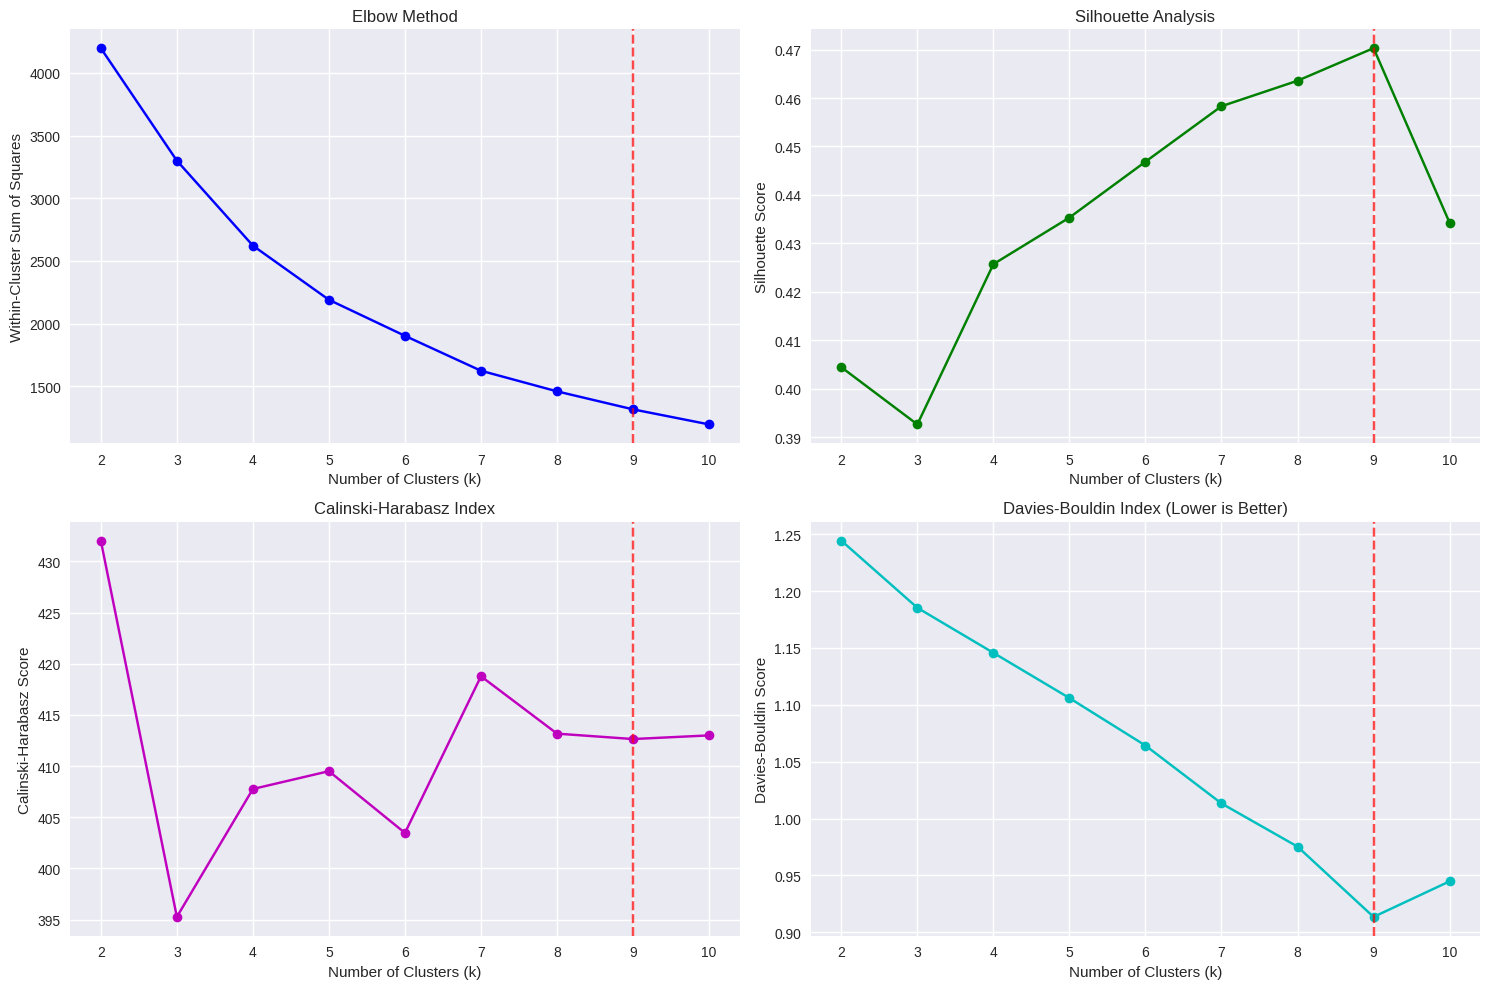


Optimal number of clusters: 9 (Silhouette Score: 0.470)


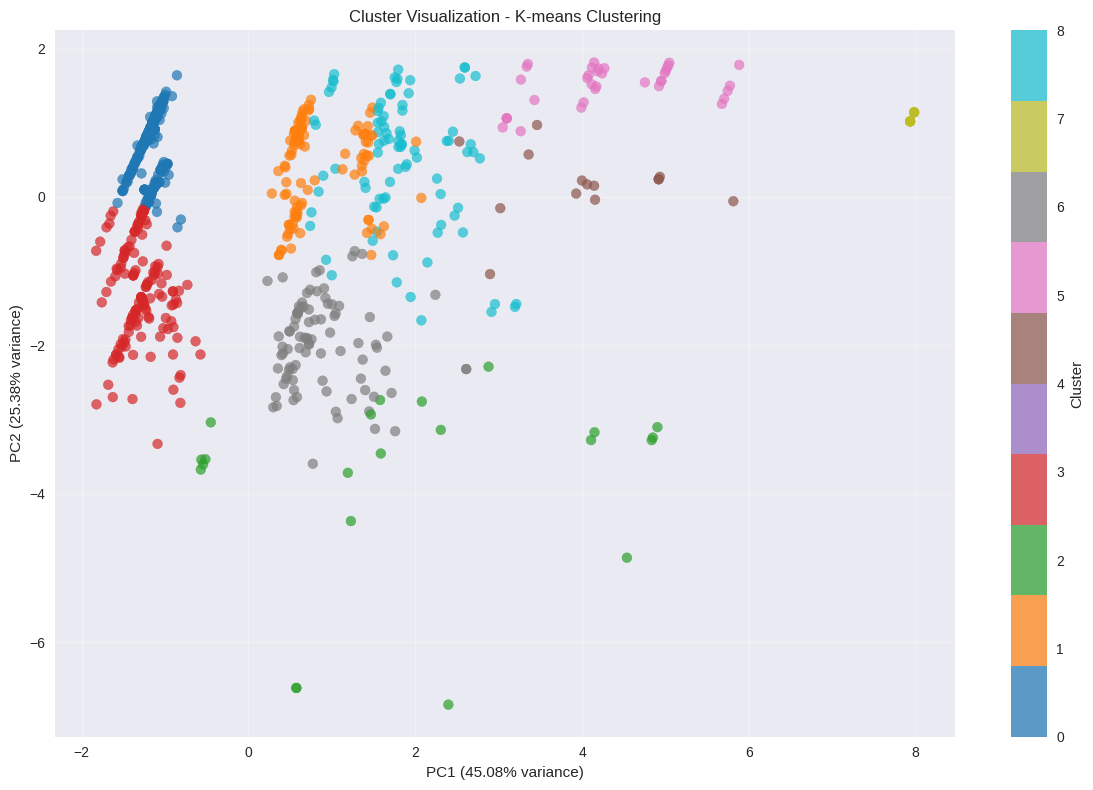


=== Hierarchical Clustering Analysis ===


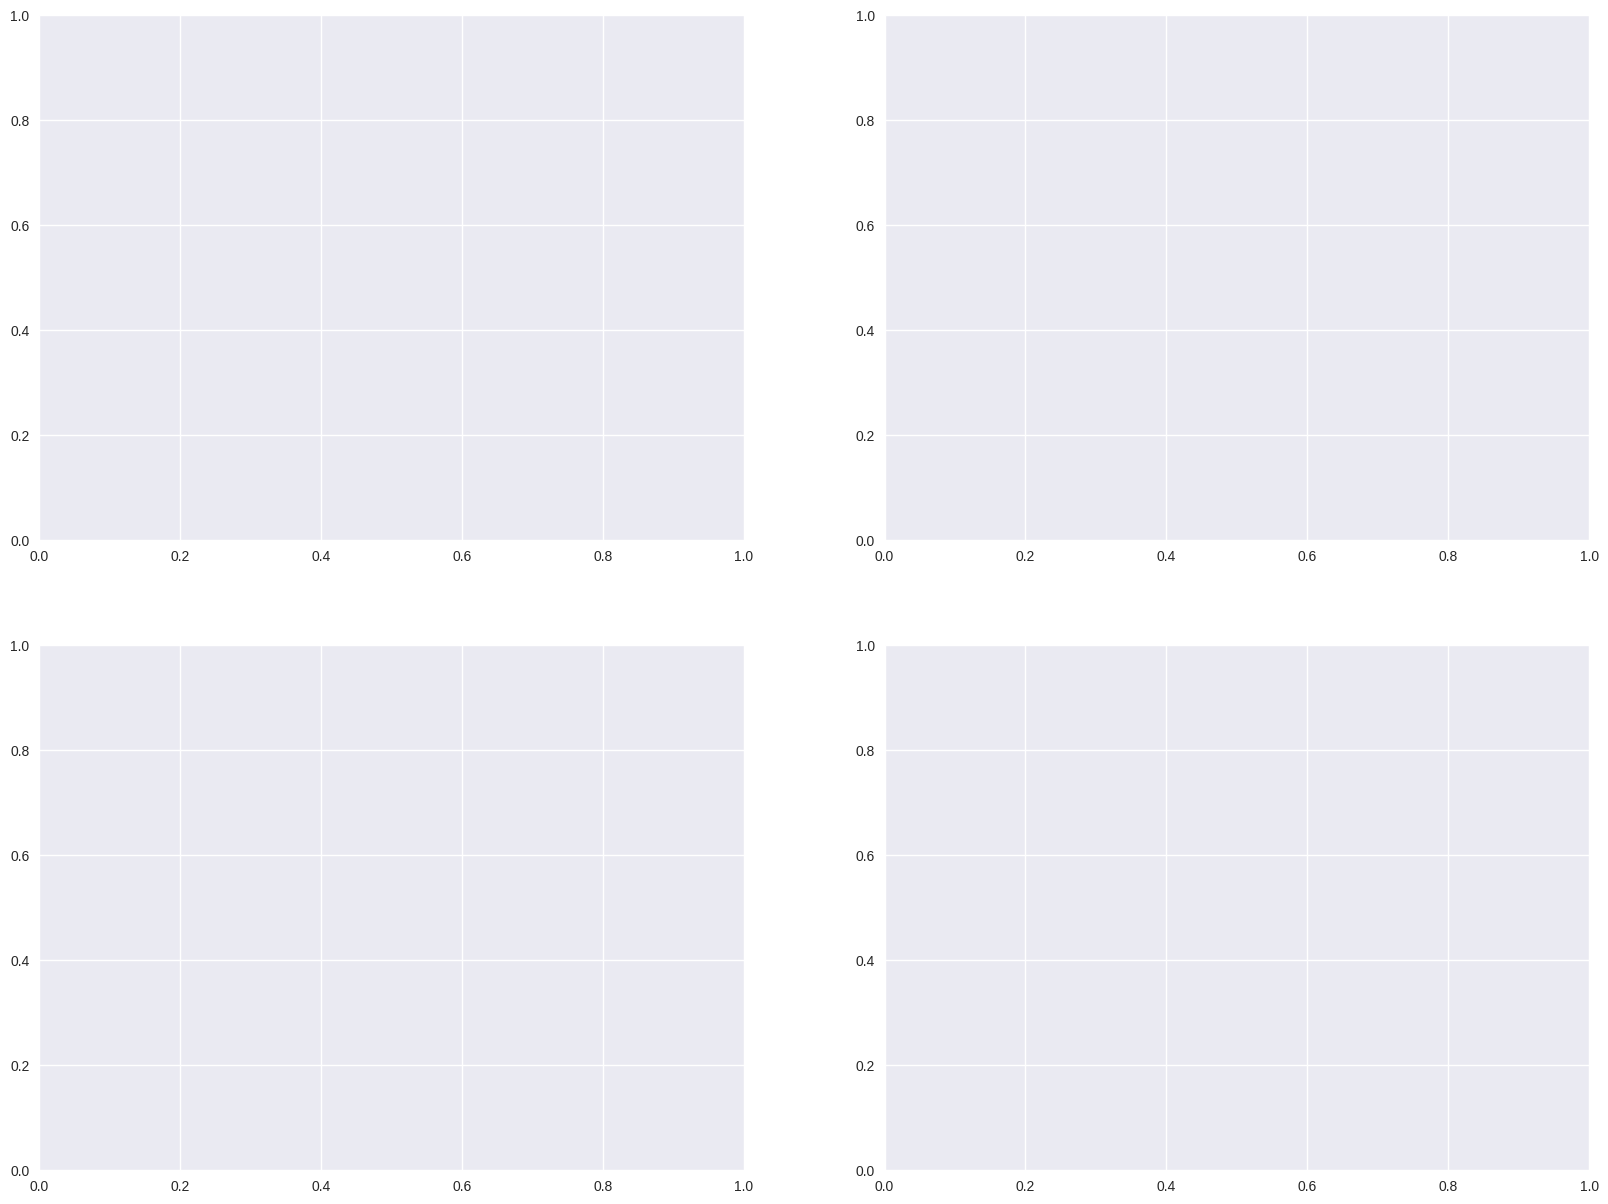

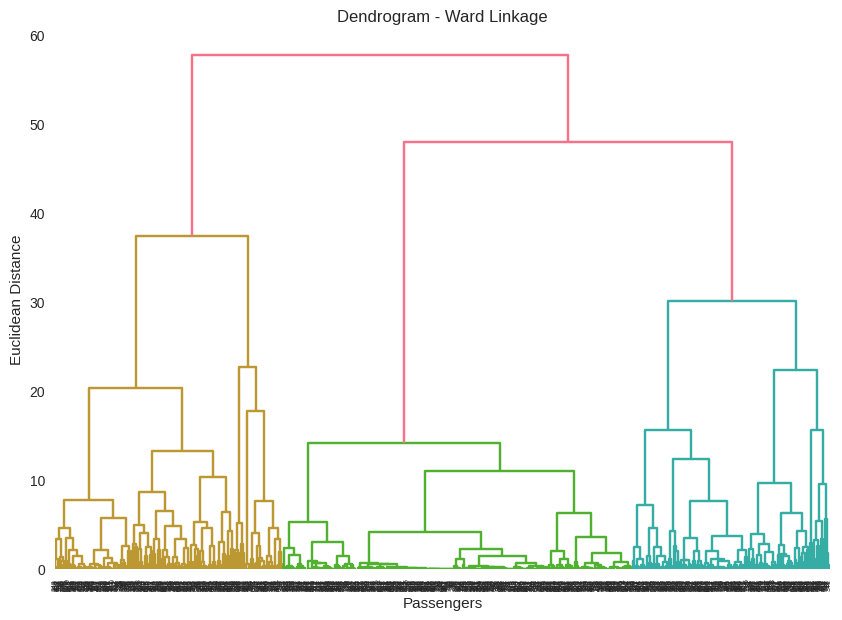

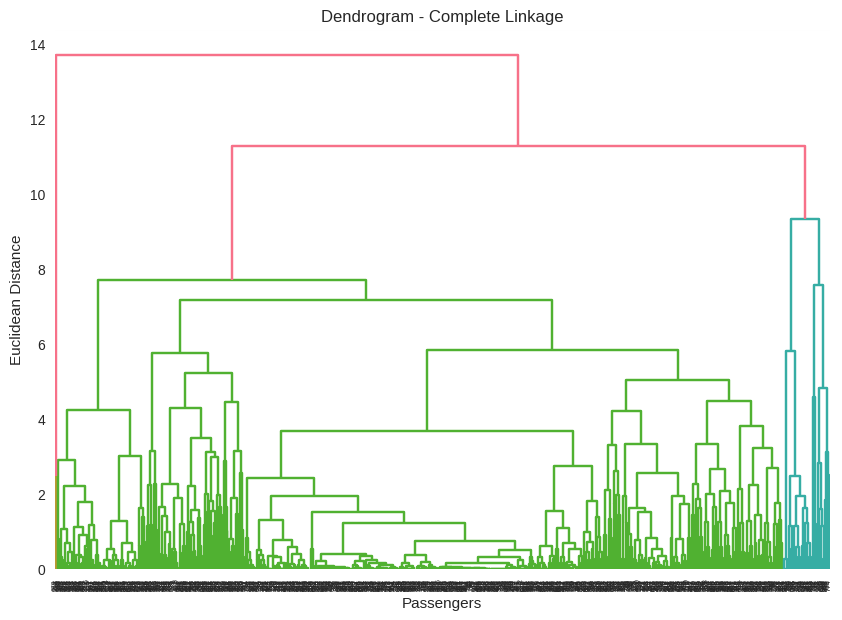

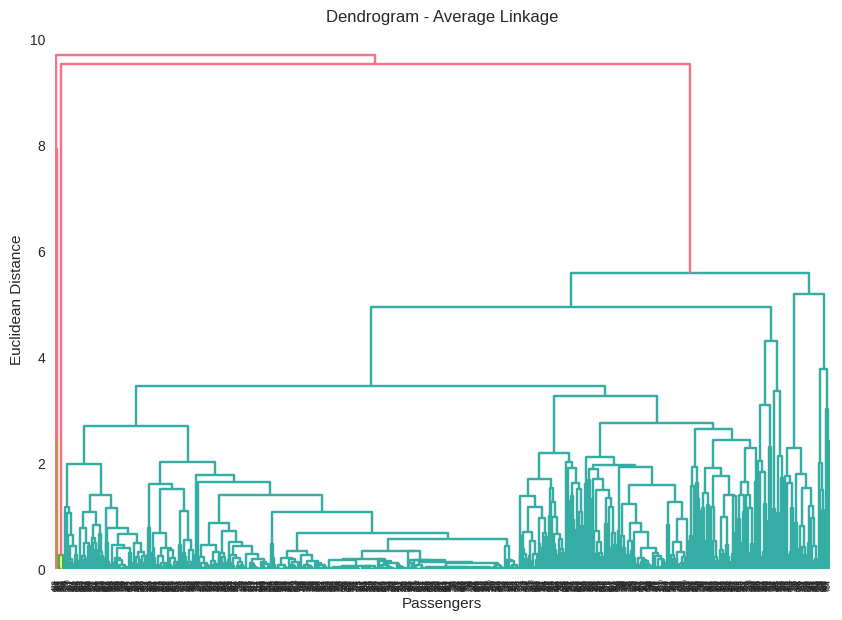

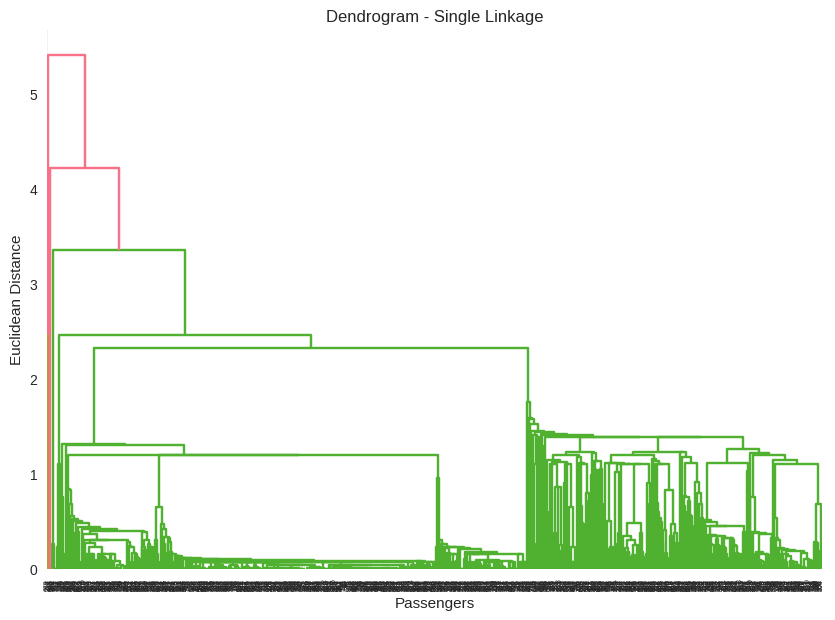

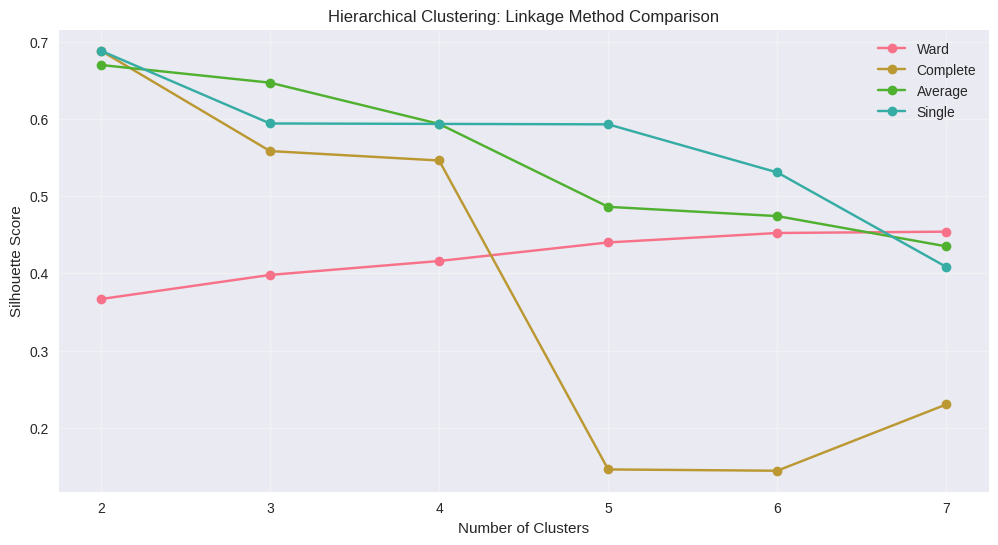

Best linkage method: complete (Silhouette Score: 0.688)


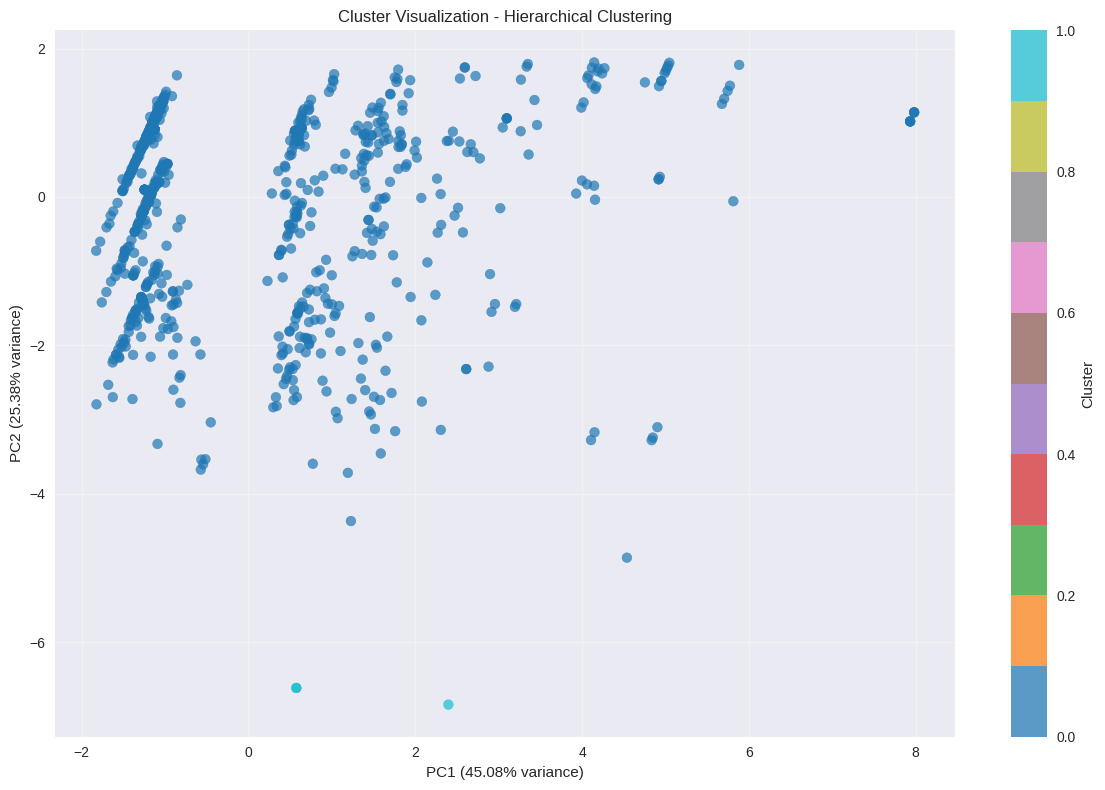


=== DBSCAN Clustering Analysis ===


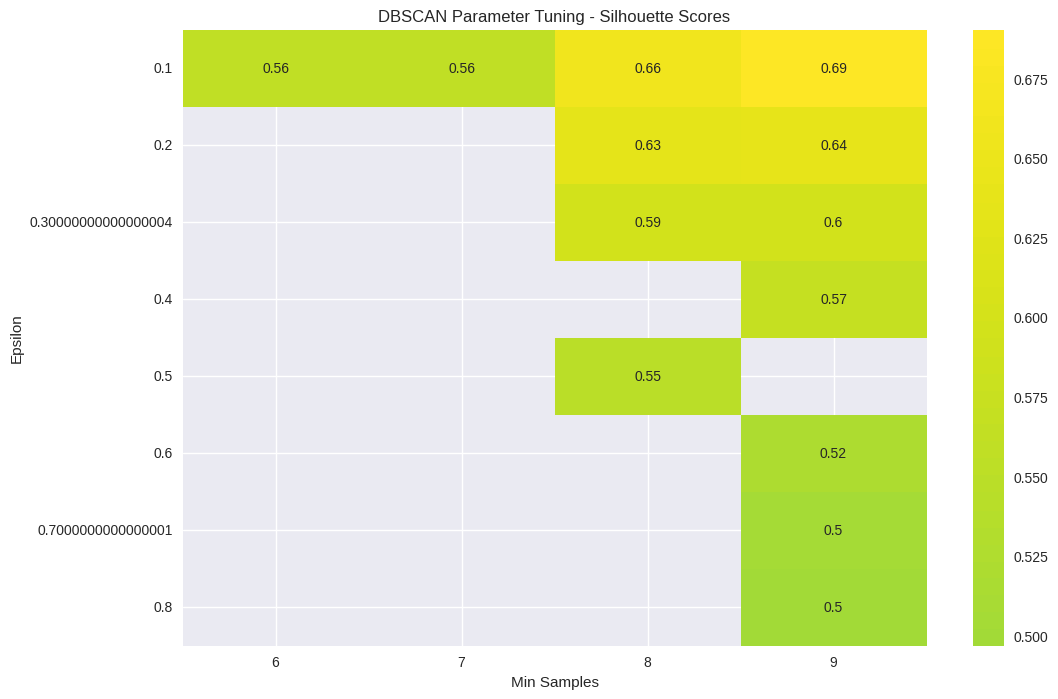

Best parameters: eps=0.10, min_samples=9
Best silhouette score: 0.690
Number of clusters: 7
Noise points: 551 (61.8%)


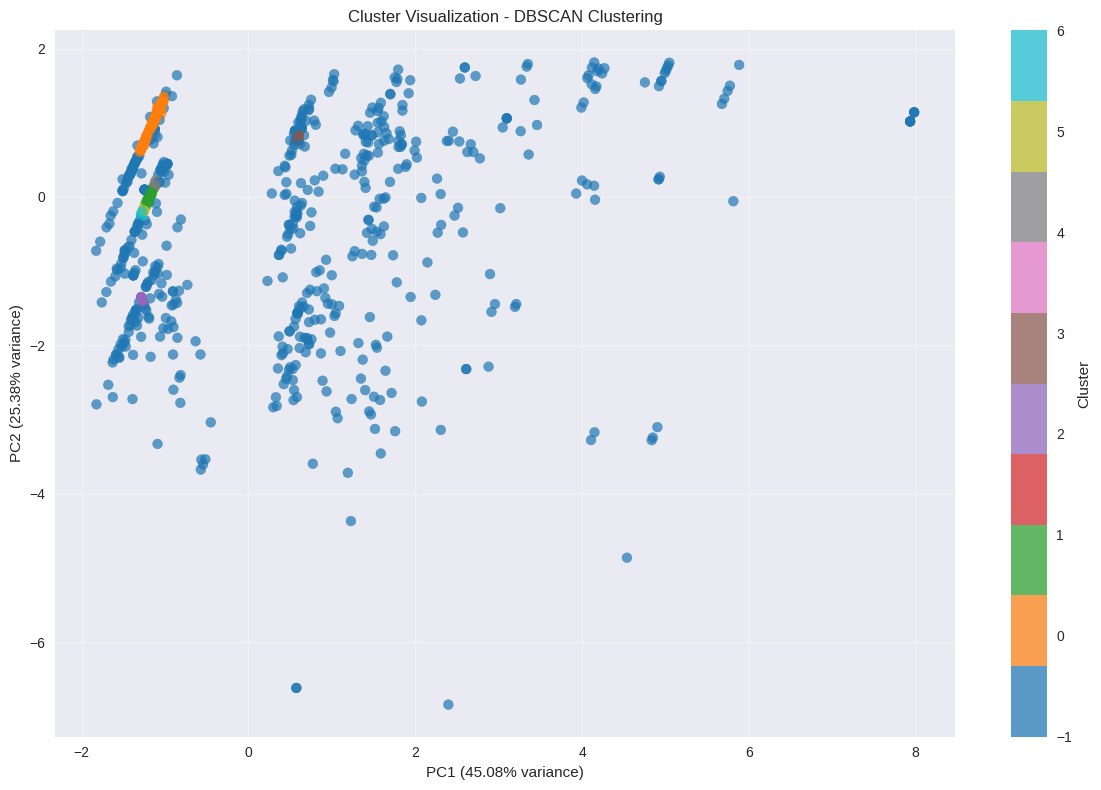

In [4]:
def perform_kmeans_clustering(X_scaled, k_range=range(2, 11)):
    """
    Implement K-means clustering with evaluation
    """
    print("=== K-means Clustering Analysis ===")

    wcss = []
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []

    best_k = 2
    best_score = -1
    best_model = None
    best_labels = None

    for k in k_range:
        # K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        wcss.append(kmeans.inertia_)
        sil_score = silhouette_score(X_scaled, labels)
        calinski_score = calinski_harabasz_score(X_scaled, labels)
        davies_score = davies_bouldin_score(X_scaled, labels)

        silhouette_scores.append(sil_score)
        calinski_scores.append(calinski_score)
        davies_scores.append(davies_score)

        print(f"K={k}: Silhouette={sil_score:.3f}, Calinski-Harabasz={calinski_score:.3f}, Davies-Bouldin={davies_score:.3f}")

        if sil_score > best_score:
            best_score = sil_score
            best_k = k
            best_model = kmeans
            best_labels = labels

    # Plot evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Elbow method
    axes[0,0].plot(k_range, wcss, 'bo-')
    axes[0,0].set_xlabel('Number of Clusters (k)')
    axes[0,0].set_ylabel('Within-Cluster Sum of Squares')
    axes[0,0].set_title('Elbow Method')
    axes[0,0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    # Silhouette scores
    axes[0,1].plot(k_range, silhouette_scores, 'go-')
    axes[0,1].set_xlabel('Number of Clusters (k)')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].set_title('Silhouette Analysis')
    axes[0,1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    # Calinski-Harabasz scores
    axes[1,0].plot(k_range, calinski_scores, 'mo-')
    axes[1,0].set_xlabel('Number of Clusters (k)')
    axes[1,0].set_ylabel('Calinski-Harabasz Score')
    axes[1,0].set_title('Calinski-Harabasz Index')
    axes[1,0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    # Davies-Bouldin scores
    axes[1,1].plot(k_range, davies_scores, 'co-')
    axes[1,1].set_xlabel('Number of Clusters (k)')
    axes[1,1].set_ylabel('Davies-Bouldin Score')
    axes[1,1].set_title('Davies-Bouldin Index (Lower is Better)')
    axes[1,1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print(f"\nOptimal number of clusters: {best_k} (Silhouette Score: {best_score:.3f})")

    return {
        'best_model': best_model,
        'best_labels': best_labels,
        'best_k': best_k,
        'metrics': {
            'wcss': wcss,
            'silhouette_scores': silhouette_scores,
            'calinski_scores': calinski_scores,
            'davies_scores': davies_scores
        }
    }

def perform_hierarchical_clustering(X_scaled, linkage_methods=['ward', 'complete', 'average', 'single']):
    """
    Implement hierarchical clustering with different linkage methods
    """
    print("\n=== Hierarchical Clustering Analysis ===")

    best_score = -1
    best_method = None
    best_labels = None
    best_model = None

    results = {}

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()

    for i, method in enumerate(linkage_methods):
        if i >= 4:
            break

        # Dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram = sch.dendrogram(sch.linkage(X_scaled, method=method))
        plt.title(f'Dendrogram - {method.capitalize()} Linkage')
        plt.xlabel('Passengers')
        plt.ylabel('Euclidean Distance')
        plt.show()

        # Hierarchical clustering for different numbers of clusters
        silhouette_scores = []
        for n_clusters in range(2, 8):
            hc = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
            labels = hc.fit_predict(X_scaled)
            sil_score = silhouette_score(X_scaled, labels)
            silhouette_scores.append(sil_score)

            if sil_score > best_score:
                best_score = sil_score
                best_method = method
                best_labels = labels
                best_model = hc

        results[method] = silhouette_scores

    # Comparison of linkage methods
    plt.figure(figsize=(12, 6))
    for method, scores in results.items():
        plt.plot(range(2, 8), scores, marker='o', label=method.capitalize())

    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Hierarchical Clustering: Linkage Method Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Best linkage method: {best_method} (Silhouette Score: {best_score:.3f})")

    return {
        'best_model': best_model,
        'best_labels': best_labels,
        'best_method': best_method,
        'results': results
    }

def perform_dbscan_clustering(X_scaled, eps_range=np.arange(0.1, 1.0, 0.1), min_samples_range=range(2, 10)):
    """
    Implement DBSCAN clustering with parameter tuning
    """
    print("\n=== DBSCAN Clustering Analysis ===")

    best_score = -1
    best_eps = None
    best_min_samples = None
    best_labels = None
    best_model = None

    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters < 2 or n_clusters > 10:
                continue

            # silhouette score
            non_noise_mask = labels != -1
            if sum(non_noise_mask) > 10:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
            else:
                sil_score = -1

            noise_ratio = np.sum(labels == -1) / len(labels)

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': sil_score,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio
            })

            if sil_score > best_score:
                best_score = sil_score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
                best_model = dbscan

    # Results DataFrame
    results_df = pd.DataFrame(results)

    if len(results_df) > 0:

        pivot_table = results_df.pivot(index='eps', columns='min_samples', values='silhouette_score')

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, cmap='viridis', center=0)
        plt.title('DBSCAN Parameter Tuning - Silhouette Scores')
        plt.xlabel('Min Samples')
        plt.ylabel('Epsilon')
        plt.show()

        print(f"Best parameters: eps={best_eps:.2f}, min_samples={best_min_samples}")
        print(f"Best silhouette score: {best_score:.3f}")
        print(f"Number of clusters: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")
        print(f"Noise points: {np.sum(best_labels == -1)} ({np.sum(best_labels == -1)/len(best_labels)*100:.1f}%)")
    else:
        print("No valid DBSCAN configurations found. Try adjusting parameter ranges.")
        best_model = None
        best_labels = None

    return {
        'best_model': best_model,
        'best_labels': best_labels,
        'best_eps': best_eps,
        'best_min_samples': best_min_samples,
        'results_df': results_df
    }

def plot_clusters(X, labels, method_name, feature_names=None):
    """
    Visualize clusters using PCA for dimensionality reduction
    """
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(X.shape[1])]

    # PCA for 2D visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(12, 8))

    # scatter plot
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7, s=50)

    # colorbar and labels
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'Cluster Visualization - {method_name}')

    if method_name.lower() == 'k-means' and hasattr(labels, 'cluster_centers_'):
        centers_pca = pca.transform(labels.cluster_centers_)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Centroids')
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return X_pca

print("\n-- PART 2: Clustering Analysis --")
X_scaled = preprocessed_data['X_scaled']

# K-means clustering
kmeans_results = perform_kmeans_clustering(X_scaled)
plot_clusters(X_scaled, kmeans_results['best_labels'], 'K-means Clustering')

# Hierarchical clustering
hierarchical_results = perform_hierarchical_clustering(X_scaled)
plot_clusters(X_scaled, hierarchical_results['best_labels'], 'Hierarchical Clustering')

# DBSCAN clustering
dbscan_results = perform_dbscan_clustering(X_scaled)
if dbscan_results['best_labels'] is not None:
    plot_clusters(X_scaled, dbscan_results['best_labels'], 'DBSCAN Clustering')

Part 3: Dimensionality Reduction


-- PART 3: Dimensionality Reduction --
-- Principal Component Analysis (PCA) --


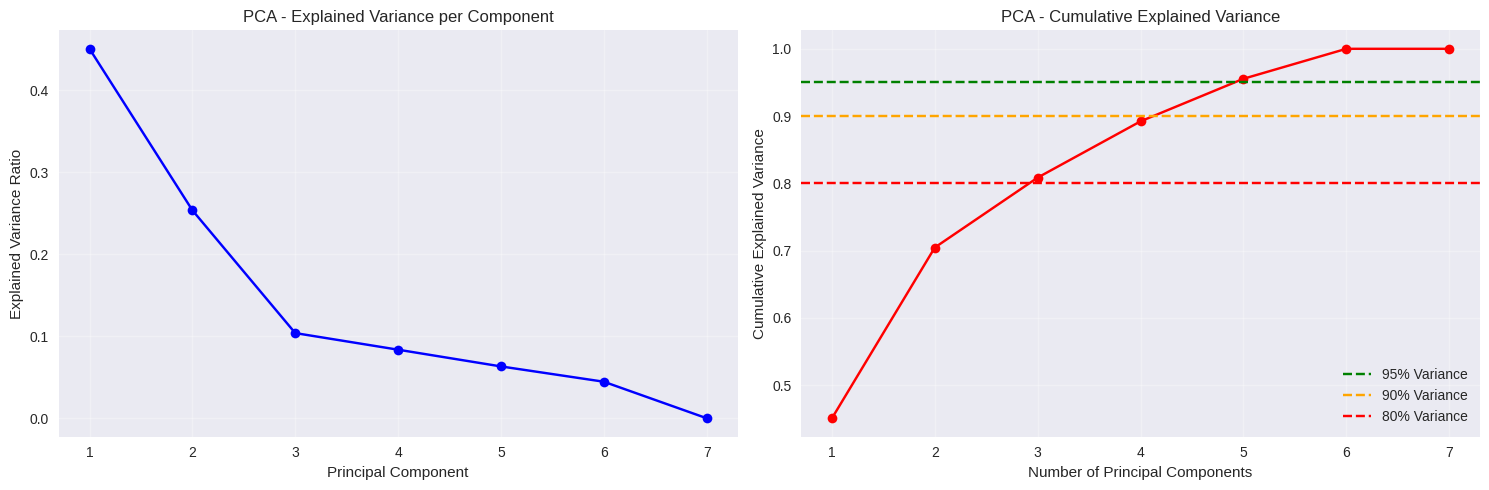

Top 5 Principal Components Analysis:

PC1 (Variance: 45.082%):
  Family_Size: 0.546
  sibsp: 0.471
  Is_Alone: -0.462

PC2 (Variance: 25.380%):
  pclass: 0.673
  fare: -0.556
  age: -0.466

PC3 (Variance: 10.393%):
  age: 0.806
  fare: -0.516
  Family_Size: 0.169

PC4 (Variance: 8.365%):
  parch: 0.737
  sibsp: -0.663
  Family_Size: -0.085

PC5 (Variance: 6.324%):
  Is_Alone: 0.706
  fare: 0.475
  pclass: 0.375

2D PCA captures 70.46% of total variance

=== Advanced Dimensionality Reduction ===
Applying t-SNE...
Applying UMAP...

--Visualizing clusters in reduced dimensional spaces--:


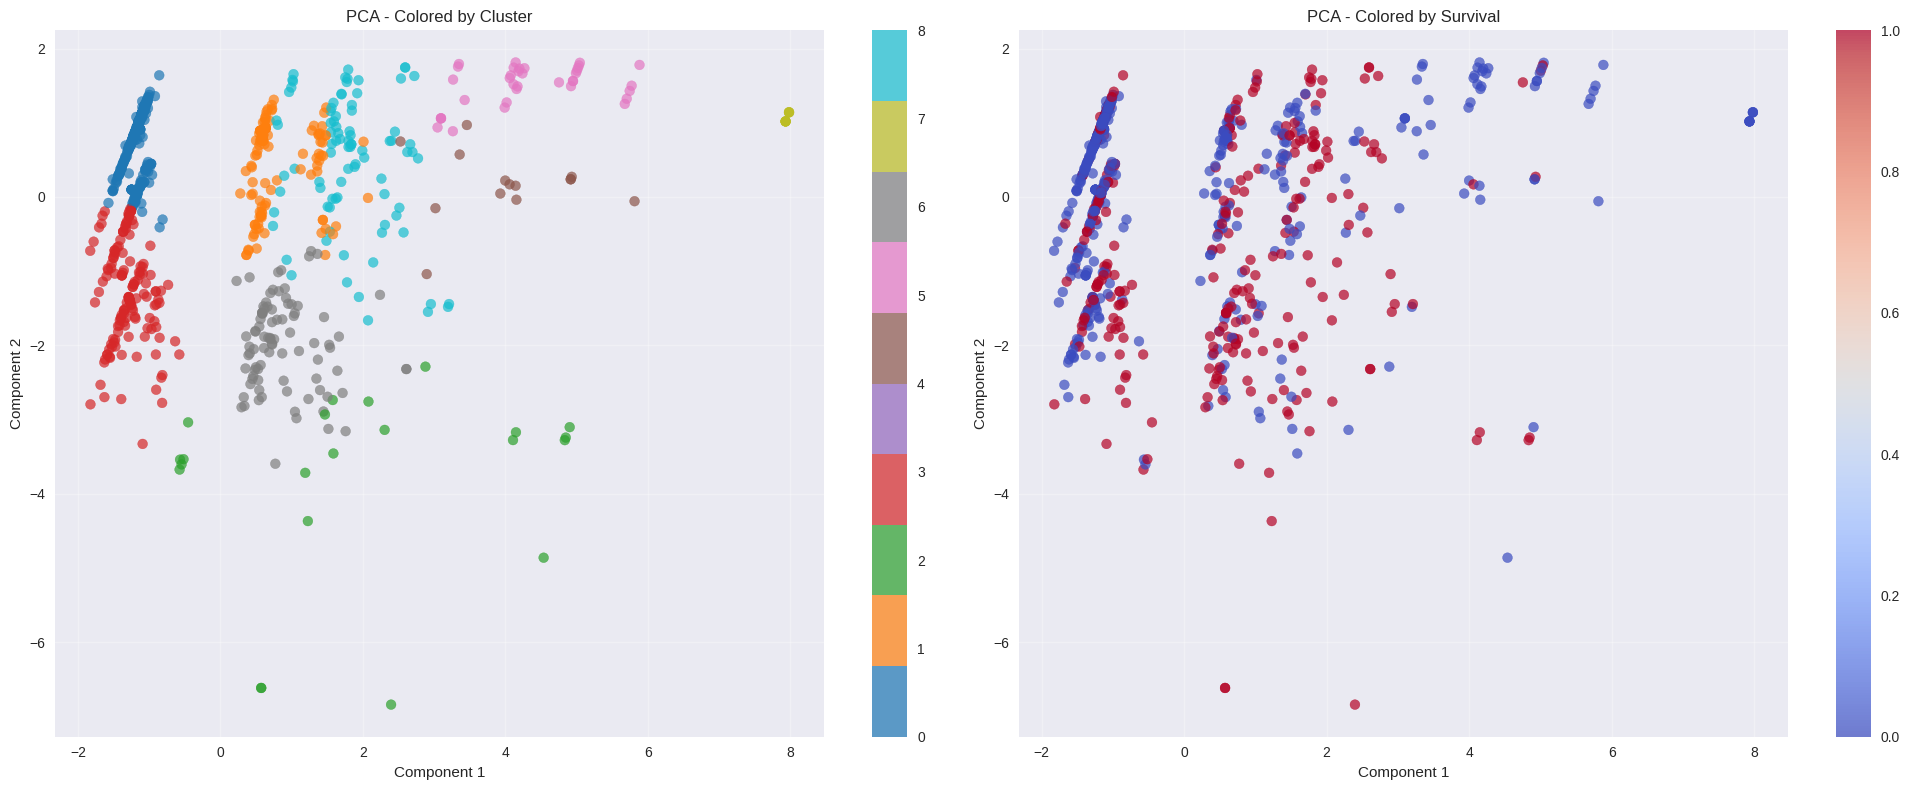

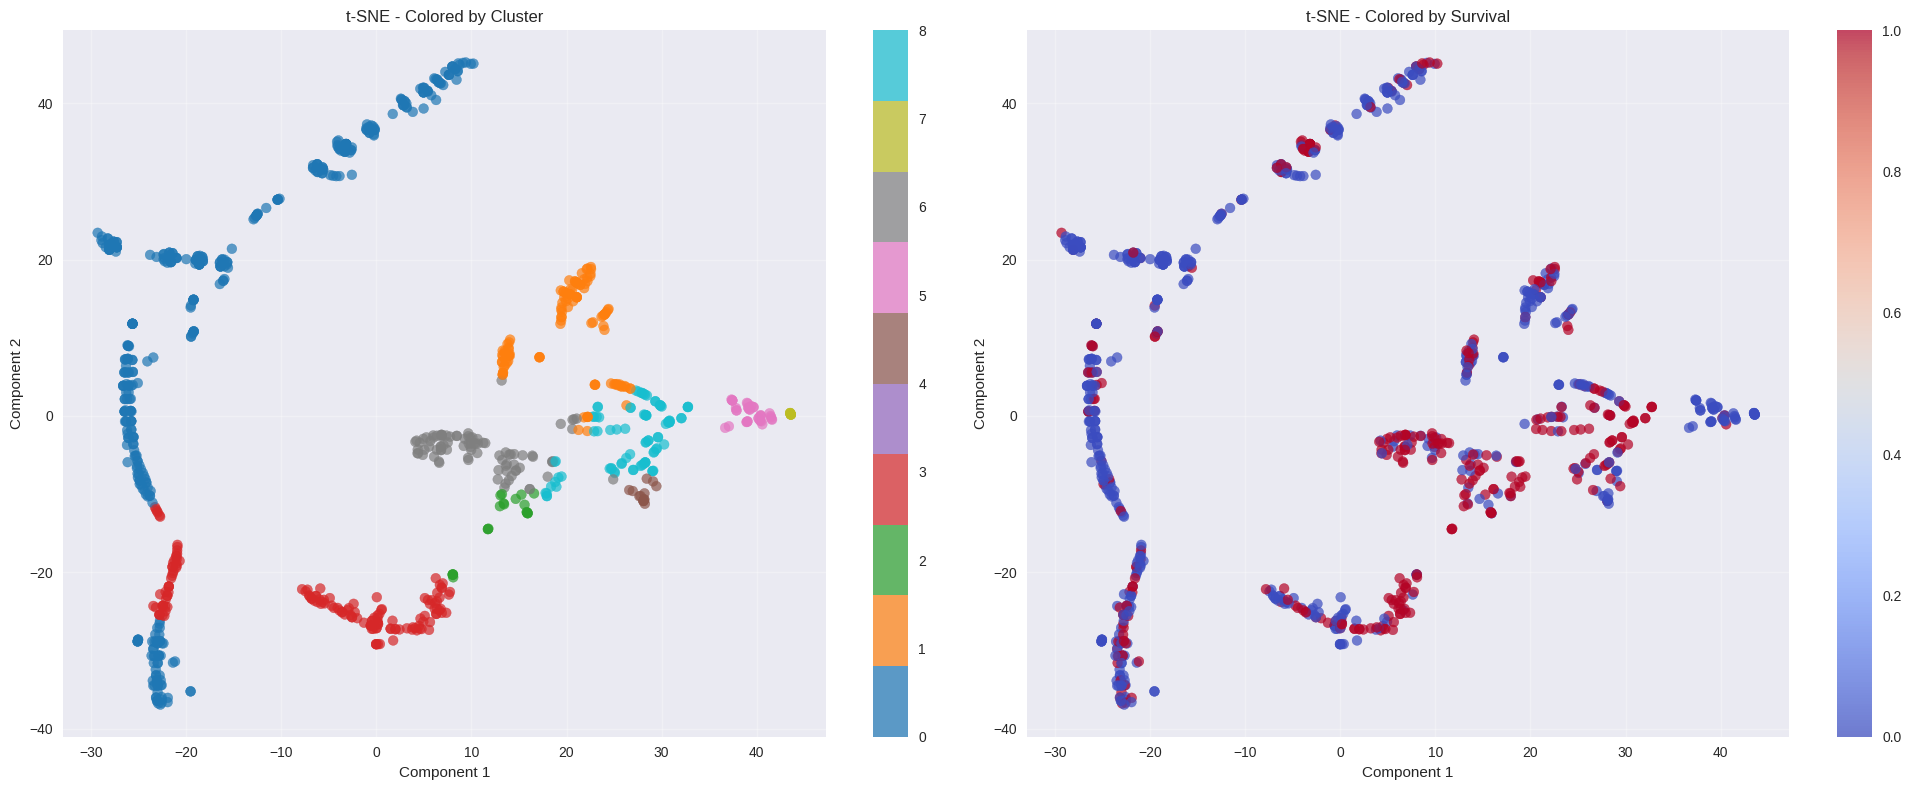

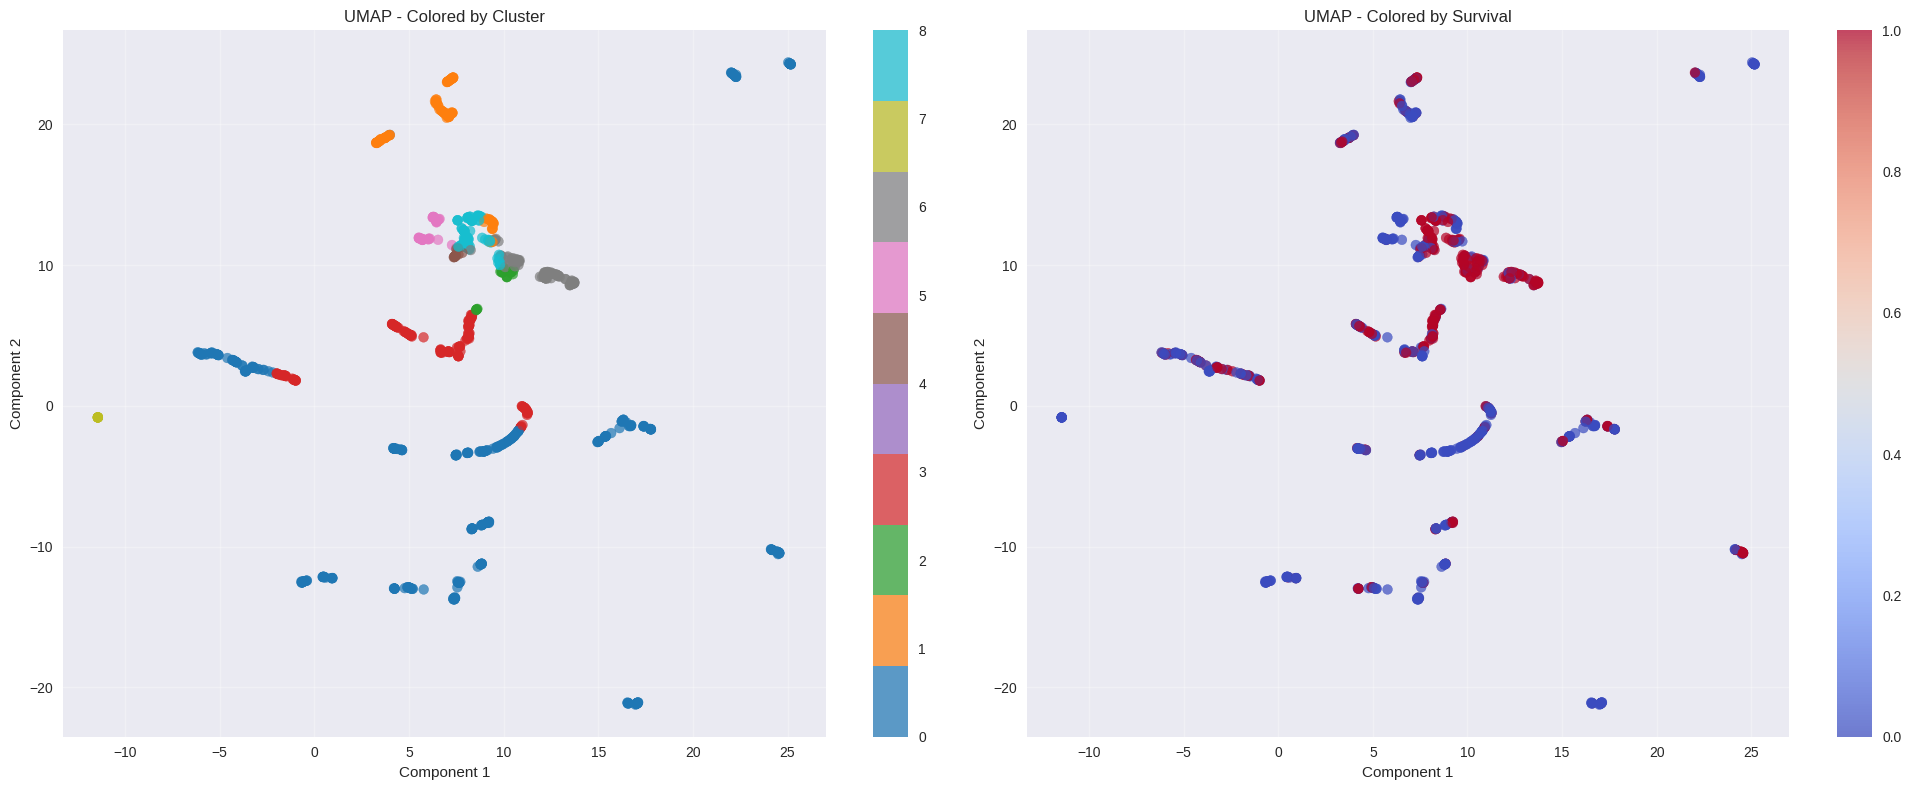

In [8]:
def apply_pca(X_scaled, n_components_range=None):

    print("-- Principal Component Analysis (PCA) --")

    if n_components_range is None:
        n_components_range = range(2, min(X_scaled.shape[1] + 1, 11))


    explained_variances = []
    cumulative_variances = []

    for n_comp in n_components_range:
        pca = PCA(n_components=n_comp)
        pca.fit(X_scaled)
        explained_variances.append(pca.explained_variance_ratio_)
        cumulative_variances.append(np.sum(pca.explained_variance_ratio_))

    pca_full = PCA()
    pca_full.fit(X_scaled)

    # explained variance
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
             pca_full.explained_variance_ratio_, 'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA - Explained Variance per Component')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
             np.cumsum(pca_full.explained_variance_ratio_), 'ro-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
    plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
    plt.axhline(y=0.80, color='red', linestyle='--', label='80% Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Top 5 Principal Components Analysis:")
    feature_names = preprocessed_data['clustering_features']
    for i, (variance, component) in enumerate(zip(pca_full.explained_variance_ratio_[:5],
                                                pca_full.components_[:5])):
        print(f"\nPC{i+1} (Variance: {variance:.3%}):")
        feature_weights = sorted(zip(feature_names, component),
                               key=lambda x: abs(x[1]), reverse=True)
        for feature, weight in feature_weights[:3]:
            print(f"  {feature}: {weight:.3f}")

    pca_2d = PCA(n_components=2)
    X_pca = pca_2d.fit_transform(X_scaled)

    print(f"\n2D PCA captures {np.sum(pca_2d.explained_variance_ratio_):.2%} of total variance")

    return {
        'pca_full': pca_full,
        'pca_2d': pca_2d,
        'X_pca': X_pca,
        'explained_variances': explained_variances,
        'cumulative_variances': cumulative_variances
    }

def apply_tsne_umap(X_scaled):
    """
    Apply t-SNE and UMAP for advanced dimensionality reduction
    """
    print("\n=== Advanced Dimensionality Reduction ===")

    # t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)

    # UMAP
    print("Applying UMAP...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = umap_reducer.fit_transform(X_scaled)

    return {
        'tsne': tsne,
        'X_tsne': X_tsne,
        'umap': umap_reducer,
        'X_umap': X_umap
    }

def plot_dimensionality_reduction(X_reduced, labels, method_name, survival_labels=None):
    """
    Visualize data in reduced dimensional space
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # cluster labels plot
    scatter1 = axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels,
                              cmap='tab10', alpha=0.7, s=50)
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    axes[0].set_title(f'{method_name} - Colored by Cluster')
    plt.colorbar(scatter1, ax=axes[0])
    axes[0].grid(True, alpha=0.3)

    if survival_labels is not None:
        scatter2 = axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=survival_labels,
                                  cmap='coolwarm', alpha=0.7, s=50)
        axes[1].set_xlabel('Component 1')
        axes[1].set_ylabel('Component 2')
        axes[1].set_title(f'{method_name} - Colored by Survival')
        plt.colorbar(scatter2, ax=axes[1])
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n-- PART 3: Dimensionality Reduction --")

# PCA
pca_results = apply_pca(X_scaled)

advanced_dr_results = apply_tsne_umap(X_scaled)

best_cluster_labels = kmeans_results['best_labels']
survival_labels = preprocessed_data['data']['survived'].values

print("\n--Visualizing clusters in reduced dimensional spaces--:")

# PCA visualization
plot_dimensionality_reduction(pca_results['X_pca'], best_cluster_labels, 'PCA', survival_labels)

# t-SNE visualization
plot_dimensionality_reduction(advanced_dr_results['X_tsne'], best_cluster_labels, 't-SNE', survival_labels)

# UMAP visualization
plot_dimensionality_reduction(advanced_dr_results['X_umap'], best_cluster_labels, 'UMAP', survival_labels)

Part 4: Survival Pattern Analysis


-- PART 4: Survival Pattern Analysis --

-- Survival Pattern Analysis - K-means Clustering --
Cluster Characteristics and Survival Rates:
         Total_Passengers  Survived_Count  Survival_Rate  Avg_Pclass  Avg_Age  \
Cluster                                                                         
8                      86              62          0.721       2.326   14.066   
6                      88              62          0.705       1.080   40.818   
2                      22              15          0.682       1.000   31.682   
3                     149              69          0.463       1.356   43.027   
1                     108              38          0.352       2.676   28.051   
4                      14               4          0.286       2.857   37.071   
0                     381              89          0.234       2.835   26.197   
5                      36               3          0.083       3.000    9.319   
7                       7               0          

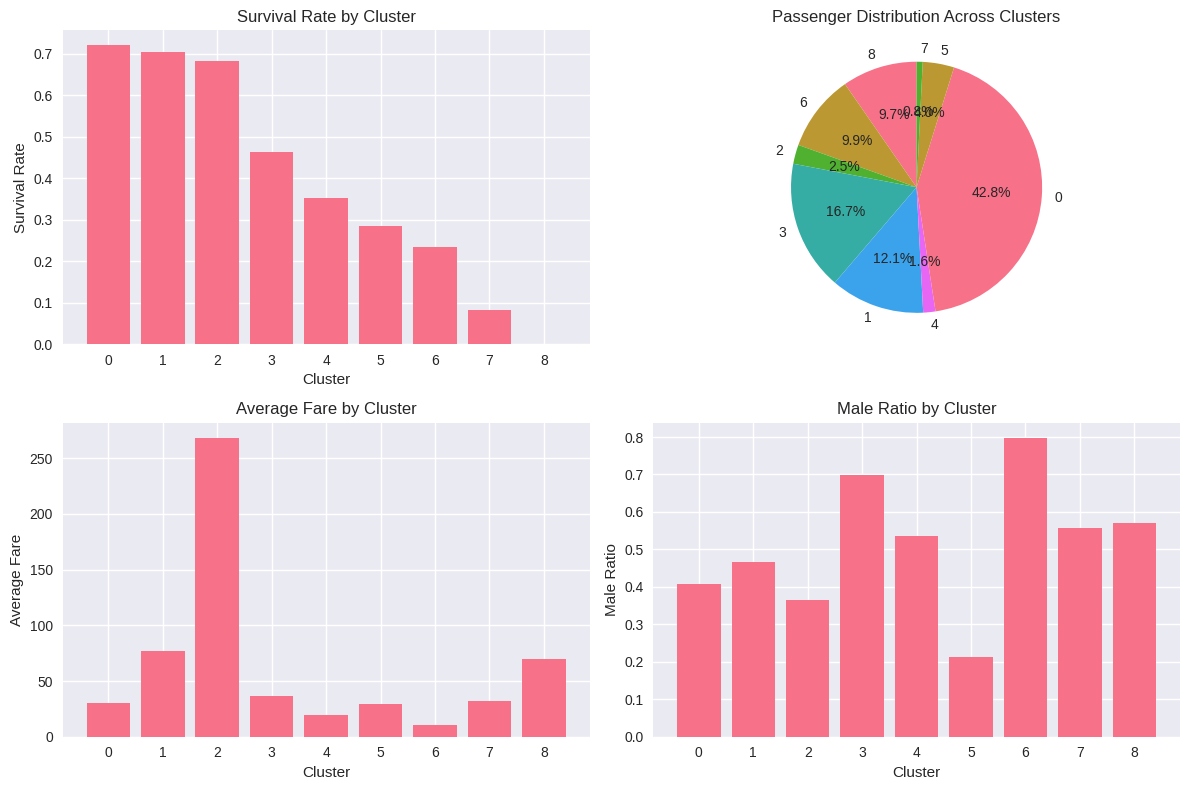


-- RISK ANALYSIS --

HIGH-RISK CLUSTERS (Survival Rate < 30%):
Cluster 4:
  - Survival Rate: 28.6%
  - Average Pclass: 2.9
  - Male Ratio: 21.4%
  - Average Age: 37.1 years
  - Average Fare: $29.7
Cluster 0:
  - Survival Rate: 23.4%
  - Average Pclass: 2.8
  - Male Ratio: 79.8%
  - Average Age: 26.2 years
  - Average Fare: $10.1
Cluster 5:
  - Survival Rate: 8.3%
  - Average Pclass: 3.0
  - Male Ratio: 55.6%
  - Average Age: 9.3 years
  - Average Fare: $32.0
Cluster 7:
  - Survival Rate: 0.0%
  - Average Pclass: 3.0
  - Male Ratio: 57.1%
  - Average Age: 23.5 years
  - Average Fare: $69.5

LOW-RISK CLUSTERS (Survival Rate > 70%):
Cluster 8:
  - Survival Rate: 72.1%
  - Average Pclass: 2.3
  - Male Ratio: 40.7%
  - Average Age: 14.1 years
  - Average Fare: $30.7
Cluster 6:
  - Survival Rate: 70.5%
  - Average Pclass: 1.1
  - Male Ratio: 46.6%
  - Average Age: 40.8 years
  - Average Fare: $76.5

-- Survival Pattern Analysis - Hierarchical Clustering --
Cluster Characteristics and Surviv

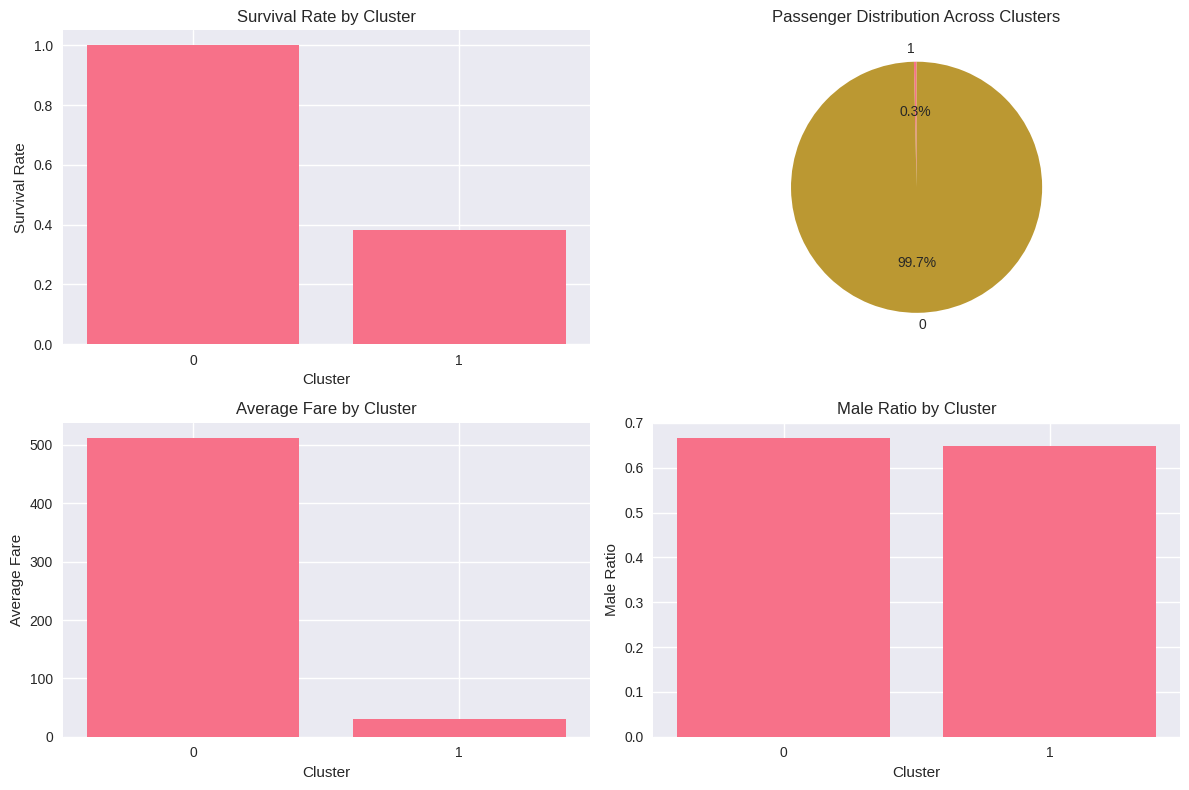


-- RISK ANALYSIS --

LOW-RISK CLUSTERS (Survival Rate > 70%):
Cluster 1:
  - Survival Rate: 100.0%
  - Average Pclass: 1.0
  - Male Ratio: 66.7%
  - Average Age: 35.3 years
  - Average Fare: $512.3

-- Survival Pattern Analysis - DBSCAN Clustering --
Cluster Characteristics and Survival Rates:
         Total_Passengers  Survived_Count  Survival_Rate  Avg_Pclass  Avg_Age  \
Cluster                                                                         
 5                      7               4          0.571       2.000   33.643   
-1                    551             259          0.470       2.031   31.153   
 1                     26              12          0.462       2.000   29.115   
 2                     15               6          0.400       1.000   40.000   
 6                      6               2          0.333       2.000   35.833   
 0                    263              56          0.213       3.000   24.363   
 4                     13               2          0.154

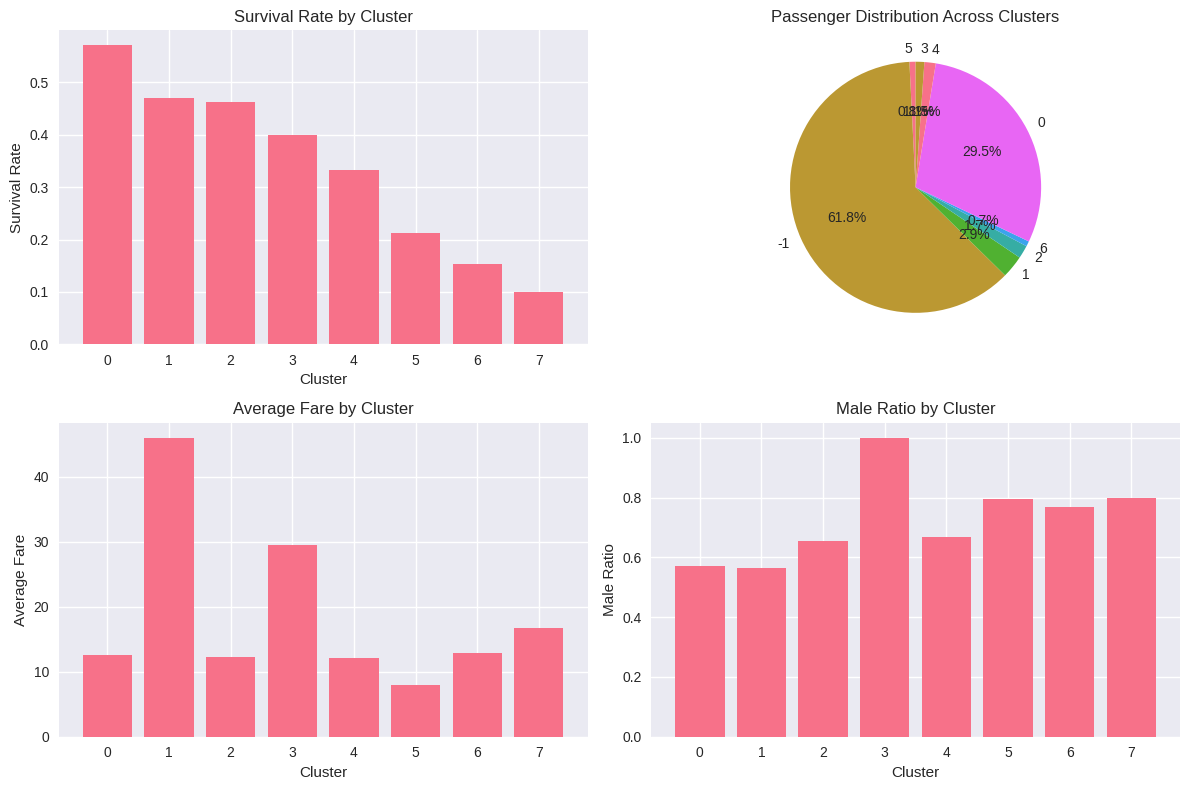


-- RISK ANALYSIS --

HIGH-RISK CLUSTERS (Survival Rate < 30%):
Cluster 0:
  - Survival Rate: 21.3%
  - Average Pclass: 3.0
  - Male Ratio: 79.5%
  - Average Age: 24.4 years
  - Average Fare: $8.0
Cluster 4:
  - Survival Rate: 15.4%
  - Average Pclass: 2.0
  - Male Ratio: 76.9%
  - Average Age: 23.8 years
  - Average Fare: $12.8
Cluster 3:
  - Survival Rate: 10.0%
  - Average Pclass: 3.0
  - Male Ratio: 80.0%
  - Average Age: 25.0 years
  - Average Fare: $16.7

-- BUSINESS INSIGHTS AND RECOMMENDATIONS --

--- Insights from K-means ---
Most Vulnerable Group (Cluster 7):
  - Survival Rate: 0.0%
  - Key Characteristics: Pclass 3.0, 57.1% male, Average age 23.5

Most Resilient Group (Cluster 8):
  - Survival Rate: 72.1%
  - Key Characteristics: Pclass 2.3, 40.7% male, Average age 14.1

RECOMMENDATIONS:
1. Emergency Preparedness:
   - Prioritize safety drills for high-risk passenger profiles
   - Ensure clear evacuation procedures for lower-class accommodations
2. Resource Allocation:
   - 

In [12]:
def analyze_survival_patterns(preprocessed_data, cluster_labels, cluster_method_name):
    """
    Analyze survival rates within clusters and provide business insights
    """
    print(f"\n-- Survival Pattern Analysis - {cluster_method_name} --")

    data = preprocessed_data['data'].copy()
    data['Cluster'] = cluster_labels

    # Calculation of survival rates by cluster
    cluster_survival = data.groupby('Cluster').agg({
        'survived': ['count', 'sum', 'mean'],
        'pclass': 'mean',
        'age': 'mean',
        'fare': 'mean',
        'sex_encoded': 'mean',
        'Family_Size': 'mean'
    }).round(3)

    cluster_survival.columns = ['Total_Passengers', 'Survived_Count', 'Survival_Rate',
                               'Avg_Pclass', 'Avg_Age', 'Avg_Fare', 'Male_Ratio', 'Avg_Family_Size']

    # survival rate
    cluster_survival = cluster_survival.sort_values('Survival_Rate', ascending=False)

    print("Cluster Characteristics and Survival Rates:")
    print(cluster_survival)

    # survival rates by cluster
    plt.figure(figsize=(12, 8))

    # Survival rate bar plot
    plt.subplot(2, 2, 1)
    plt.bar(range(len(cluster_survival)), cluster_survival['Survival_Rate'])
    plt.xlabel('Cluster')
    plt.ylabel('Survival Rate')
    plt.title('Survival Rate by Cluster')
    plt.xticks(range(len(cluster_survival)))

    # Passenger distribution
    plt.subplot(2, 2, 2)
    plt.pie(cluster_survival['Total_Passengers'], labels=cluster_survival.index,
            autopct='%1.1f%%', startangle=90)
    plt.title('Passenger Distribution Across Clusters')

    # Average fare by cluster
    plt.subplot(2, 2, 3)
    plt.bar(range(len(cluster_survival)), cluster_survival['Avg_Fare'])
    plt.xlabel('Cluster')
    plt.ylabel('Average Fare')
    plt.title('Average Fare by Cluster')
    plt.xticks(range(len(cluster_survival)))

    # Male ratio by cluster
    plt.subplot(2, 2, 4)
    plt.bar(range(len(cluster_survival)), cluster_survival['Male_Ratio'])
    plt.xlabel('Cluster')
    plt.ylabel('Male Ratio')
    plt.title('Male Ratio by Cluster')
    plt.xticks(range(len(cluster_survival)))

    plt.tight_layout()
    plt.show()

    # Identifying high-risk and low-risk clusters
    high_risk_clusters = cluster_survival[cluster_survival['Survival_Rate'] < 0.3]
    low_risk_clusters = cluster_survival[cluster_survival['Survival_Rate'] > 0.7]

    print("\n-- RISK ANALYSIS --")
    if not high_risk_clusters.empty:
        print(f"\nHIGH-RISK CLUSTERS (Survival Rate < 30%):")
        for cluster_idx in high_risk_clusters.index:
            cluster_data = high_risk_clusters.loc[cluster_idx]
            print(f"Cluster {cluster_idx}:")
            print(f"  - Survival Rate: {cluster_data['Survival_Rate']:.1%}")
            print(f"  - Average Pclass: {cluster_data['Avg_Pclass']:.1f}")
            print(f"  - Male Ratio: {cluster_data['Male_Ratio']:.1%}")
            print(f"  - Average Age: {cluster_data['Avg_Age']:.1f} years")
            print(f"  - Average Fare: ${cluster_data['Avg_Fare']:.1f}")

    if not low_risk_clusters.empty:
        print(f"\nLOW-RISK CLUSTERS (Survival Rate > 70%):")
        for cluster_idx in low_risk_clusters.index:
            cluster_data = low_risk_clusters.loc[cluster_idx]
            print(f"Cluster {cluster_idx}:")
            print(f"  - Survival Rate: {cluster_data['Survival_Rate']:.1%}")
            print(f"  - Average Pclass: {cluster_data['Avg_Pclass']:.1f}")
            print(f"  - Male Ratio: {cluster_data['Male_Ratio']:.1%}")
            print(f"  - Average Age: {cluster_data['Avg_Age']:.1f} years")
            print(f"  - Average Fare: ${cluster_data['Avg_Fare']:.1f}")

    return cluster_survival

def provide_business_insights(cluster_analysis_results):
    """
    Generate actionable business insights from clustering results
    """
    print("\n-- BUSINESS INSIGHTS AND RECOMMENDATIONS --")

    for method_name, analysis in cluster_analysis_results.items():
        print(f"\n--- Insights from {method_name} ---")

        cluster_survival = analysis['cluster_survival']

        # Most vulnerable group
        most_vulnerable = cluster_survival.loc[cluster_survival['Survival_Rate'].idxmin()]
        most_resilient = cluster_survival.loc[cluster_survival['Survival_Rate'].idxmax()]

        print(f"Most Vulnerable Group (Cluster {cluster_survival['Survival_Rate'].idxmin()}):")
        print(f"  - Survival Rate: {most_vulnerable['Survival_Rate']:.1%}")
        print(f"  - Key Characteristics: Pclass {most_vulnerable['Avg_Pclass']:.1f}, "
              f"{most_vulnerable['Male_Ratio']:.1%} male, "
              f"Average age {most_vulnerable['Avg_Age']:.1f}")

        print(f"\nMost Resilient Group (Cluster {cluster_survival['Survival_Rate'].idxmax()}):")
        print(f"  - Survival Rate: {most_resilient['Survival_Rate']:.1%}")
        print (f"  - Key Characteristics: Pclass {most_resilient['Avg_Pclass']:.1f}, "
              f"{most_resilient['Male_Ratio']:.1%} male, "
              f"Average age {most_resilient['Avg_Age']:.1f}")

        # Recommendations
        print(f"\nRECOMMENDATIONS:")
        print("1. Emergency Preparedness:")
        print("   - Prioritize safety drills for high-risk passenger profiles")
        print("   - Ensure clear evacuation procedures for lower-class accommodations")

        print("2. Resource Allocation:")
        print("   - Position more lifeboats near high-density vulnerable areas")
        print("   - Train crew to assist demographic groups with lower survival rates")

        print("3. Policy Considerations:")
        print("   - Review evacuation protocols for identified risk factors")
        print("   - Consider demographic-aware safety measures")


print("\n-- PART 4: Survival Pattern Analysis --")

# Analyzing survival patterns for each clustering method
cluster_analysis_results = {}

# K-means survival analysis
kmeans_survival = analyze_survival_patterns(preprocessed_data,
                                          kmeans_results['best_labels'],
                                          "K-means Clustering")
cluster_analysis_results['K-means'] = {
    'cluster_survival': kmeans_survival,
    'model': kmeans_results['best_model']
}

# Hierarchical clustering survival analysis
hierarchical_survival = analyze_survival_patterns(preprocessed_data,
                                                hierarchical_results['best_labels'],
                                                "Hierarchical Clustering")
cluster_analysis_results['Hierarchical'] = {
    'cluster_survival': hierarchical_survival,
    'model': hierarchical_results['best_model']
}

# DBSCAN survival analysis
if dbscan_results['best_labels'] is not None:
    dbscan_survival = analyze_survival_patterns(preprocessed_data,
                                              dbscan_results['best_labels'],
                                              "DBSCAN Clustering")
    cluster_analysis_results['DBSCAN'] = {
        'cluster_survival': dbscan_survival,
        'model': dbscan_results['best_model']
    }

provide_business_insights(cluster_analysis_results)

# Final comparison of clustering methods
print("\n--- CLUSTERING METHOD COMPARISON ---")
comparison_data = []

for method_name, results in cluster_analysis_results.items():
    cluster_survival = results['cluster_survival']
    silhouette_avg = silhouette_score(X_scaled,
                                    kmeans_results['best_labels'] if method_name == 'K-means'
                                    else hierarchical_results['best_labels'] if method_name == 'Hierarchical'
                                    else dbscan_results['best_labels'])

    comparison_data.append({
        'Method': method_name,
        'Number of Clusters': len(cluster_survival),
        'Avg Silhouette Score': silhouette_avg,
        'Survival Rate Range': f"{cluster_survival['Survival_Rate'].min():.1%} - {cluster_survival['Survival_Rate'].max():.1%}",
        'Best Cluster Survival': f"{cluster_survival['Survival_Rate'].max():.1%}",
        'Worst Cluster Survival': f"{cluster_survival['Survival_Rate'].min():.1%}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

Summary and Conclusions

In [16]:
def generate_summary_report(preprocessed_data, clustering_results, dr_results, survival_analysis):
    """
    Generate a comprehensive summary report of the analysis
    """
    print("="*80)
    print("TITANIC PASSENGER CLUSTERING AND SURVIVAL ANALYSIS - SUMMARY REPORT")
    print("="*80)

    # Dataset summary
    data = preprocessed_data['data']
    print(f"\nDATASET OVERVIEW:")
    print(f"Total Passengers: {len(data)}")
    print(f"Overall Survival Rate: {data['survived'].mean():.1%}")
    print(f"Features Used for Clustering: {len(preprocessed_data['clustering_features'])}")
    print(f"Clustering Features: {', '.join(preprocessed_data['clustering_features'])}")


    print(f"\nKEY FINDINGS:")

    # Best clustering method (using silhouette score as a metric)
    # Note: Silhouette score requires more than one cluster and more than one sample in each cluster.
    # If a method results in only one cluster or clusters with single samples, silhouette_score will raise an error.
    # We'll handle this by checking for valid silhouette scores or using a different metric if necessary.

    best_method = None
    best_silhouette = -1

    for method_name, results in clustering_results.items():
        labels = results['best_labels']

        if len(set(labels)) > 1 and min([list(labels).count(c) for c in set(labels)]) > 1:
             #  X_scaled from preprocessed_data which is consistent
            try:
                sil_score = silhouette_score(preprocessed_data['X_scaled'], labels)
                if sil_score > best_silhouette:
                    best_silhouette = sil_score
                    best_method = method_name
            except Exception as e:
                print(f"Could not calculate silhouette score for {method_name}: {e}")
                pass
        else:
             print(f"Skipping silhouette score for {method_name} due to insufficient clusters or samples.")


    if best_method:
        print(f"1. Best Performing Clustering Method (based on Silhouette Score): {best_method}")
    else:
        print("1. Could not determine best performing clustering method based on Silhouette Score.")


    # Most significant risk factors (correlation with survival from original data)
    numeric_data = data.select_dtypes(include=[np.number])
    correlation_with_survival = numeric_data.corr()['survived'].sort_values(key=abs, ascending=False)
    top_risk_factors = correlation_with_survival[1:4]
    print(f"2. Top Risk Factors (correlation with survival):")
    for factor, corr in top_risk_factors.items():
        print(f"   - {factor}: {corr:.3f}")

    # Cluster insights
    print(f"3. Cluster-Based Insights:")
    for method_name, analysis in survival_analysis.items():
        cluster_survival = analysis['cluster_survival']

        if len(cluster_survival) > 1:
            survival_range = cluster_survival['Survival_Rate'].max() - cluster_survival['Survival_Rate'].min()
            print(f"   - {method_name}: Survival rate varies by {survival_range:.1%} across clusters")
        else:
            print(f"   - {method_name}: Only one cluster found, survival rate range not applicable.")


    # Dimensionality reduction insights
    if dr_results and 'pca_2d' in dr_results:
        pca_variance = np.sum(dr_results['pca_2d'].explained_variance_ratio_)
        print(f"4. Dimensionality Reduction:")
        print(f"   - 2D PCA captures {pca_variance:.1%} of total variance")
        # Assuming t-SNE and UMAP were applied if dr_results is not None
        print(f"   - t-SNE and UMAP reveal non-linear patterns in passenger data")
    else:
        print("4. Dimensionality Reduction results not available.")

    print(f"\nRECOMMENDATIONS FOR FUTURE SAFETY:")
    print("1. Implement demographic-aware evacuation protocols")
    print("2. Prioritize safety resources for identified high-risk groups")
    print("3. Conduct regular drills focusing on vulnerable passenger profiles")
    print("4. Use cluster analysis for emergency response planning")


generate_summary_report(preprocessed_data,
                      {'K-means': kmeans_results, 'Hierarchical': hierarchical_results, 'DBSCAN': dbscan_results},
                      pca_results,
                      cluster_analysis_results)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

TITANIC PASSENGER CLUSTERING AND SURVIVAL ANALYSIS - SUMMARY REPORT

DATASET OVERVIEW:
Total Passengers: 891
Overall Survival Rate: 38.4%
Features Used for Clustering: 7
Clustering Features: pclass, age, sibsp, parch, fare, Family_Size, Is_Alone

KEY FINDINGS:
1. Best Performing Clustering Method (based on Silhouette Score): Hierarchical
2. Top Risk Factors (correlation with survival):
   - sex_encoded: -0.543
   - pclass: -0.338
   - Deck_encoded: -0.295
3. Cluster-Based Insights:
   - K-means: Survival rate varies by 72.1% across clusters
   - Hierarchical: Survival rate varies by 61.8% across clusters
   - DBSCAN: Survival rate varies by 47.1% across clusters
4. Dimensionality Reduction:
   - 2D PCA captures 70.5% of total variance
   - t-SNE and UMAP reveal non-linear patterns in passenger data

RECOMMENDATIONS FOR FUTURE SAFETY:
1. Implement demographic-aware evacuation protocols
2. Prioritize safety resources for identified high-risk groups
3. Conduct regular drills focusing on v